## import libraries

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
from glob import glob
import re
from galvani import BioLogic

from function import read_mpr

import pymysql
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.widgets import Slider,CheckButtons

from scipy.signal import savgol_filter,find_peaks
from tqdm import tqdm

import time
from collections import Counter
from pandas import Series

from impedance.visualization import plot_nyquist
from impedance import preprocessing

from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import BayesianRidge
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectFromModel


In [3]:
import seaborn as sns

from sklearn import svm, metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit

from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import mean_squared_error


## import data

#### read Formation data

In [18]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

In [136]:
#load data from folder
df_form = read_mpr.mpr_pandas('raw_data/form')

FileNotFoundError: [WinError 3] The system cannot find the path specified: 'raw_data/form'

In [ ]:
read_mpr.searchmpr('raw_data/form')

In [ ]:
df_form[3]

#### add serval columns

In [ ]:
# list paths of data in .mpr file
datafilespath = glob('raw_data/form/*.mpr')
datafilespath =  [os.path.basename(x) for x in datafilespath]

In [ ]:
datafilespath

#### half cycle and state of charge


In [ ]:
#set half cycle of discharge processes to 1 in gcpl
#ds[3,7,11...]
discharge_index = np.arange(3,np.shape(datafilespath)[0],4)
for index in discharge_index:
    df_form[index]['half cycle']=1
#set state of charge in geis
cell_empty_index = np.arange(0,np.shape(datafilespath)[0],4)
cell_full_index = np.arange(2,np.shape(datafilespath)[0],4)
for index in cell_empty_index:
    df_form[index]['state of charge']=0
for index in cell_full_index:
    df_form[index]['state of charge']=1

In [ ]:
discharge_index = np.arange(3,np.shape(datafilespath)[0],4)
discharge_index

#### read Cycling data

In [2]:
df_cycle = read_mpr.mpr_pandas('raw_data/cycle')

NameError: name 'read_mpr' is not defined

In [3]:
cyc_files = glob('raw_data/cycle/*.mpr')
for file in cyc_files:
    try:
        BioLogic.MPRfile(file)
    except:
        print('files: '+file+' is unreadable')

## Create EIS datasheets

In [4]:
dbhost='127.0.0.1'
dbport=3306
dbuser='root'
dbpassword='Acakeren13!'
connection_name='SSB_Modelling'
db = ['cell001','cell002','cell003','cell004','cell005','cell006','cell007','cell008']

EISdata = Series()

for cell in db:
    Connection = pymysql.connect(host=dbhost,
                              port=dbport,
                              user=dbuser,
                              password=dbpassword,
                              database=cell)
    
    
    ##formation phase
    sql = 'SELECT `control/V/mA` FROM ' +cell+ '.form_gcpl'
    control_i = pd.read_sql(sql, Connection)
    i = control_i.at[5,'control/V/mA']*1000 # mA to uA
    
    sql = 'SELECT `freq/Hz`,`Re(Z)/Ohm`,`-Im(Z)/Ohm`,`cycle_Nr` FROM ' +cell+ '.form_geis WHERE `state of charge`=0'
    cellx_df_form = pd.read_sql(sql, Connection)
  
    
    for f in pd.unique(cellx_df_form['freq/Hz']):
        Z= cellx_df_form[cellx_df_form['freq/Hz']==f][['cycle_Nr','Re(Z)/Ohm','-Im(Z)/Ohm']]
        Z.columns = ['cycle_Nr','Re(Z)'+str(f),'-Im(Z)'+str(f)]
        if f==10001.0: 
            EISdata_form = Z
            Temp = EISdata_form
        else:
            EISdata_form = pd.merge(Z, Temp)
            Temp = EISdata_form
    EISdata_form.insert(EISdata_form.shape[1],'I(uA)',i)   
        
    
    ##cycling phase
    sql = 'SELECT `control/V/mA` FROM ' +cell+ '.cyc_gcpl'
    control_i = pd.read_sql(sql, Connection)
    i = control_i.at[5,'control/V/mA']*1000 # mA to uA
    
    sql = 'SELECT `freq/Hz`,`Re(Z)/Ohm`,`-Im(Z)/Ohm`,`cycle_Nr` FROM ' +cell+ '.cyc_geis' 
    cellx_df_cyc = pd.read_sql(sql, Connection)
    
    for f in pd.unique(cellx_df_cyc['freq/Hz']):
        Z_f = cellx_df_cyc[cellx_df_cyc['freq/Hz']==f]
        Z = Z_f[['cycle_Nr','Re(Z)/Ohm','-Im(Z)/Ohm']]
        Z.columns = ['cycle_Nr','Re(Z)'+str(f),'-Im(Z)'+str(f)]
        if f==10001.0: 
            EISdata_cyc = Z
            Temp = EISdata_cyc
        else:
            EISdata_cyc = pd.merge(Z, Temp)
            Temp = EISdata_cyc
    EISdata_cyc.insert(EISdata_cyc.shape[1],'I(uA)',i)
    
    
    ##combine two phases
    EISdata = pd.concat([EISdata, EISdata_form, EISdata_cyc])
   

C:\Users\azhar\AppData\Local\Temp/ipykernel_25656/2761111867.py:8: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  EISdata = Series()


In [5]:
EISdata

,0,-Im(Z)0.00931323,-Im(Z)0.0139698,-Im(Z)0.0209548,-Im(Z)0.0325963,-Im(Z)0.0488944,-Im(Z)0.0721775,-Im(Z)0.107102,-Im(Z)0.158325,-Im(Z)0.235159,...,Re(Z)425.149,Re(Z)4542.0,Re(Z)5.53438,Re(Z)59.0552,Re(Z)630.738,Re(Z)6740.0,Re(Z)8.21194,Re(Z)87.684,Re(Z)936.063,cycle_Nr
0,NaN,46573.100,41140.600,38890.600,33659.900,28336.300,24173.400,20196.100,16555.000,13207.800,...,4069.380,780.681,19795.400,11042.900,3192.450,576.129,18729.900,9338.710,2468.640,1.0
1,NaN,744.727,680.813,646.593,610.109,590.529,556.290,536.941,519.400,501.626,...,1094.290,440.624,2186.520,1607.920,984.566,352.459,2090.170,1508.630,871.517,2.0
2,NaN,466.609,418.363,371.091,330.920,302.348,281.000,260.804,243.710,227.845,...,280.388,178.468,510.757,363.399,265.193,157.575,480.894,344.816,249.524,3.0
3,NaN,321.803,268.775,249.611,213.158,191.325,173.753,158.885,147.645,137.494,...,194.233,120.451,329.958,247.109,183.140,107.645,313.046,235.716,171.382,4.0
4,NaN,306.783,257.149,232.201,198.357,176.400,162.611,148.172,137.131,126.416,...,200.602,120.529,326.963,253.938,188.869,107.826,312.557,243.248,175.909,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4,NaN,928.158,787.140,746.442,658.180,608.807,571.038,539.620,511.625,481.045,...,610.890,297.738,1339.490,947.509,551.273,255.368,1273.070,877.947,494.135,51.0
5,NaN,950.003,851.159,748.695,695.747,650.527,607.119,567.820,532.886,503.491,...,654.759,311.267,1443.940,1021.890,589.334,265.472,1372.430,947.176,526.326,61.0
6,NaN,981.726,844.923,815.402,721.606,668.781,628.138,591.708,561.631,529.389,...,676.418,317.095,1513.180,1067.040,606.722,270.461,1438.550,987.266,540.827,71.0
7,NaN,1008.600,938.403,824.233,772.940,716.481,675.717,633.844,593.506,557.258,...,717.194,328.901,1621.590,1141.040,641.104,279.113,1541.250,1054.600,569.741,81.0


In [6]:
### du brauchst wahrscheinlich nur die Re und Im data davon, kein cycle und I(uA) columns

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 1000)

In [7]:
# remove unnecessary columns

EISdata_defaultIndex = EISdata.reset_index()
EISdata_defaultIndex = EISdata_defaultIndex.drop(columns=[0, 'index'], axis=1)
df = EISdata_defaultIndex.drop(['I(uA)'], axis=1)

In [8]:
df

,-Im(Z)0.00931323,-Im(Z)0.0139698,-Im(Z)0.0209548,-Im(Z)0.0325963,-Im(Z)0.0488944,-Im(Z)0.0721775,-Im(Z)0.107102,-Im(Z)0.158325,-Im(Z)0.235159,-Im(Z)0.349246,-Im(Z)0.516884,-Im(Z)0.768341,-Im(Z)1.14087,-Im(Z)1.69268,-Im(Z)10001.0,-Im(Z)12.184,-Im(Z)130.089,-Im(Z)1390.0,-Im(Z)18.077,-Im(Z)193.035,-Im(Z)2.51224,-Im(Z)2063.0,-Im(Z)26.8198,-Im(Z)286.568,-Im(Z)3.72762,-Im(Z)3061.0,-Im(Z)39.8047,-Im(Z)425.149,-Im(Z)4542.0,-Im(Z)5.53438,-Im(Z)59.0552,-Im(Z)630.738,-Im(Z)6740.0,-Im(Z)8.21194,-Im(Z)87.684,-Im(Z)936.063,Re(Z)0.00931323,Re(Z)0.0139698,Re(Z)0.0209548,Re(Z)0.0325963,Re(Z)0.0488944,Re(Z)0.0721775,Re(Z)0.107102,Re(Z)0.158325,Re(Z)0.235159,Re(Z)0.349246,Re(Z)0.516884,Re(Z)0.768341,Re(Z)1.14087,Re(Z)1.69268,Re(Z)10001.0,Re(Z)12.184,Re(Z)130.089,Re(Z)1390.0,Re(Z)18.077,Re(Z)193.035,Re(Z)2.51224,Re(Z)2063.0,Re(Z)26.8198,Re(Z)286.568,Re(Z)3.72762,Re(Z)3061.0,Re(Z)39.8047,Re(Z)425.149,Re(Z)4542.0,Re(Z)5.53438,Re(Z)59.0552,Re(Z)630.738,Re(Z)6740.0,Re(Z)8.21194,Re(Z)87.684,Re(Z)936.063,cycle_Nr
0,46573.100,41140.600,38890.600,33659.900,28336.300,24173.400,20196.100,16555.000,13207.800,10576.300,8611.6100,7190.6900,6144.1500,5456.8400,672.4060,5420.3300,5485.3400,2323.9300,5765.9900,4982.9000,5028.8300,1897.7100,6042.4300,4430.5000,4859.8000,1524.2000,6176.7800,3866.3000,1205.8100,4894.3700,6119.7600,3317.3600,936.6760,5102.0500,5880.8000,2800.1600,48852.200,39784.600,41164.000,38284.100,36293.000,34619.900,33395.900,31923.100,29705.900,27811.100,26130.500,24760.200,23657.600,22631.500,20.1169,17502.500,7757.960,1880.170,16096.200,6342.670,21682.400,1414.240,14510.900,5113.740,20756.500,1052.980,12797.500,4069.380,780.681,19795.400,11042.900,3192.450,576.1290,18729.900,9338.710,2468.640,1.0
1,744.727,680.813,646.593,610.109,590.529,556.290,536.941,519.400,501.626,487.526,467.5730,454.9510,440.4530,426.8480,268.2390,396.1900,407.3670,412.0380,395.9820,412.0590,416.1920,397.2940,396.8690,416.4100,407.9980,373.8830,398.4090,420.8400,342.6310,402.0700,400.7430,422.6130,305.1430,397.8870,403.3690,420.3120,4262.660,4109.630,3915.340,3753.190,3632.000,3460.850,3348.260,3218.560,3078.250,2946.450,2822.570,2700.920,2590.080,2484.030,281.6410,1995.490,1408.270,757.618,1900.880,1306.460,2381.540,645.912,1803.470,1201.520,2283.000,539.758,1706.100,1094.290,440.624,2186.520,1607.920,984.566,352.4590,2090.170,1508.630,871.517,2.0
2,466.609,418.363,371.091,330.920,302.348,281.000,260.804,243.710,227.845,210.987,198.8820,183.2670,171.3510,158.8230,68.9481,107.9490,72.0086,68.8636,100.7000,68.9930,147.5560,70.6000,93.2055,66.9526,136.4600,72.8279,86.4027,66.5611,73.8025,126.3200,80.9338,66.2011,72.0772,117.0240,75.7917,67.2323,1475.700,1343.660,1274.420,1175.120,1100.940,1028.560,962.757,910.590,857.347,802.499,751.674,703.080,658.154,616.449,133.8640,453.213,327.460,233.199,427.910,311.452,578.052,215.901,404.793,295.629,542.789,197.916,383.227,280.388,178.468,510.757,363.399,265.193,157.5750,480.894,344.816,249.524,3.0
3,321.803,268.775,249.611,213.158,191.325,173.753,158.885,147.645,137.494,126.374,116.5500,108.8120,100.1830,92.5046,41.8847,61.7613,44.7237,47.1922,56.6283,44.0103,85.2114,47.9426,53.0079,44.2800,78.4868,47.5855,50.0939,44.5810,46.9005,72.1142,47.8761,45.8549,44.2770,66.5918,45.8550,46.5797,903.619,836.947,776.234,724.889,679.224,637.350,594.803,561.326,529.737,499.811,469.155,441.935,415.801,390.880,94.0251,297.233,225.743,159.388,283.382,214.917,368.401,147.119,270.346,204.546,348.606,133.406,258.188,194.233,120.451,329.958,247.109,183.140,107.6450,313.046,235.716,171.382,4.0
4,306.783,257.149,232.201,198.357,176.400,162.611,148.172,137.131,126.416,115.821,108.3500,99.3348,92.3194,84.5710,40.9052,55.9140,44.1545,51.4133,51.5017,44.4741,77.8437,51.3697,48.4032,45.8164,70.9826,50.1709,46.4533,47.2396,48.6607,65.2540,44.8741,49.4135,45.6482,60.3146,43.4377,50.2708,860.372,787.428,740.479,687.780,644.641,608.289,568.839,536.578,508.108,479.451,452.389,427.071,403.495,381.796,95.3007,298.701,233.305,162.078,286.042,222.746,361.857,148.

# Data Preprocessing

In [403]:
# separate cells by cycle number

cells = []

start = 0
for i in df.index:
    if df['cycle_Nr'].iloc[i] > df['cycle_Nr'].shift(-1).fillna(1).iloc[i]:
        end = i+1
        cells.append(df.iloc[start:end])
        start = end
        
# im and re for plotting and separating -im and re

cells_im = []
cells_re = []

for cell in cells:
    im = cell[cell.columns.drop(list(cell.filter(regex='Re')))].drop('cycle_Nr', axis=1)
    cells_im.append(im)
    
    re = cell[cell.columns.drop(list(cell.filter(regex='Im')))].drop('cycle_Nr', axis=1)
    cells_re.append(re)

In [404]:
# choose frequency for selecting points to compare

freqs = []
freqs.append(cells_re[0].columns[-1][5:])
freqs.append(cells_re[0].columns[-5][5:])
freqs.append(cells_re[0].columns[-9][5:])

print(freqs)

['936.063', '630.738', '425.149']


<IPython.core.display.Javascript object>


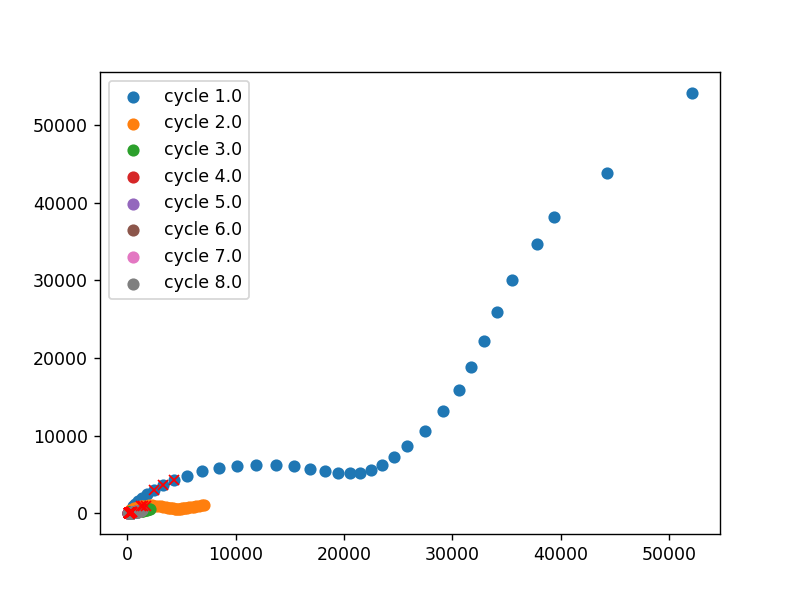

In [338]:
# plot

cell = 3

for i in range(0, 8):
    plt.scatter(cells_re[cell].iloc[i], cells_im[cell].iloc[i], label='cycle {}'.format(cells[cell]['cycle_Nr'].iloc[i]))
    for j in freqs:
        re = 'Re(Z){}'.format(j)
        im = '-Im(Z){}'.format(j)
        plt.plot(cells_re[cell].iloc[i][re], cells_im[cell].iloc[i][im], 'x', c='red')
    plt.legend()


In [405]:
# make a function to return the abnormal rows from the dataframe
# by using the points chosen from frequency for each cell and
# compare absolute values difference from each cell

res = []
ims = []
abnormal_index = []
for count, cell in enumerate(cells):
    X = []
    Y = []
    for i in range(len(cell)):
        x = []
        y = []
        for j in freqs:
            re = 'Re(Z){}'.format(j)
            im = '-Im(Z){}'.format(j)
            x.append(cells_re[count].iloc[i][re])
            y.append(cells_im[count].iloc[i][im])
        X.append(x)
        Y.append(y)
    res.append(X)
    ims.append(Y)
    
absolute = []
for i in range(len(cells)):
    absolute.append( np.absolute( np.sqrt( np.array(np.power(res[i], 2)) + np.array(np.power(ims[i], 2) ))))

abnormal_index = []
for count, i in enumerate(absolute):
    for count, j in enumerate(i):
        res = np.sum(np.array(i[count])) - np.sum(np.array(i[count+1]))
        if res < 0:
            abnormal_index.append(count+1)
            break

In [402]:
# resulting abnormal index

abnormal_index

[4, 4, 5, 4, 5, 6, 6, 6]

## divide data to normal and abnormal

In [379]:
# use abnormal index list from algorithm above to determine abnormal / good data
 
df_unfilter = df.drop(['cycle_Nr'], axis=1)
df_abnormal = pd.DataFrame(columns=df.columns)
df_normal = pd.DataFrame(columns=df.columns)

# 
for count, cell in enumerate(cells):
    df_abnormal = df_abnormal.append(cell.loc[cell['cycle_Nr'] <= abnormal_index[count]], ignore_index=True)
    df_normal = df_normal.append(cell.loc[cell['cycle_Nr'] > abnormal_index[count]], ignore_index=True)

    
# drop cycle number
# for checking, comment the two lines below to see the cycle numbers
df_normal = df_normal.drop('cycle_Nr', axis=1)
df_abnormal = df_abnormal.drop('cycle_Nr', axis=1)

    
# transform data
df_unfilter_trans = np.log(df_unfilter) # try with log10 or log 2
df_normal_trans = np.log(df_normal)
df_abnormal_trans = np.log(df_abnormal)

In [380]:
# dividing dfs

df_im_normal = df_normal[df_normal.columns.drop(list(df_normal.filter(regex='Re')))]
df_im_abnormal = df_abnormal[df_abnormal.columns.drop(list(df_abnormal.filter(regex='Re')))]
df_re_normal = df_normal[df_normal.columns.drop(list(df_normal.filter(regex='Im')))]
df_re_abnormal = df_abnormal[df_abnormal.columns.drop(list(df_abnormal.filter(regex='Im')))]
df_im_unfilter = df_unfilter[df_unfilter.columns.drop(list(df_unfilter.filter(regex='Re')))]
df_re_unfilter = df_unfilter[df_unfilter.columns.drop(list(df_unfilter.filter(regex='Im')))]
df_im_unfilter_t = df_unfilter_trans[df_unfilter_trans.columns.drop(list(df_unfilter_trans.filter(regex='Re')))]
df_re_unfilter_t = df_unfilter_trans[df_unfilter_trans.columns.drop(list(df_unfilter_trans.filter(regex='Im')))]

## plot

<IPython.core.display.Javascript object>


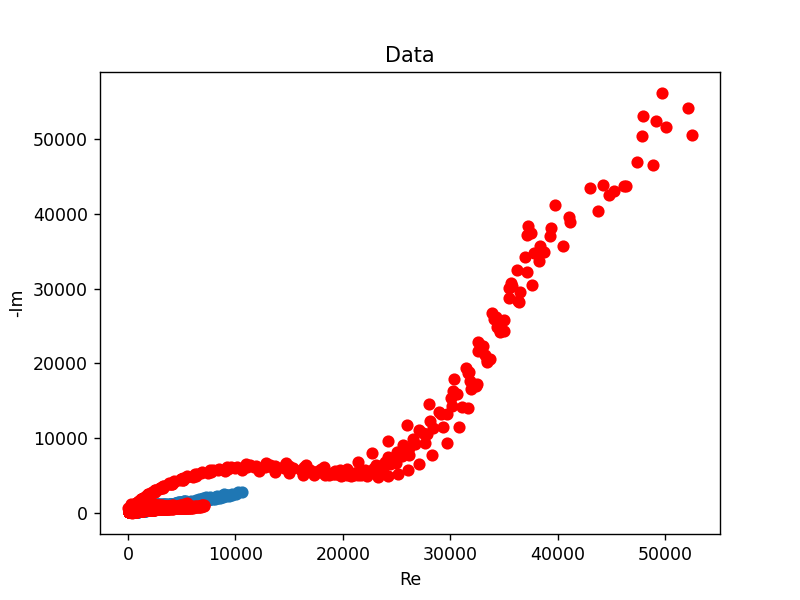

In [446]:
# normal and abnormal df comparison

plt.scatter(df_re_normal, df_im_normal)
plt.scatter(df_re_abnormal, df_im_abnormal, color='r')
plt.title('Data')
plt.ylabel('-Im')
plt.xlabel('Re')
plt.show()

<IPython.core.display.Javascript object>


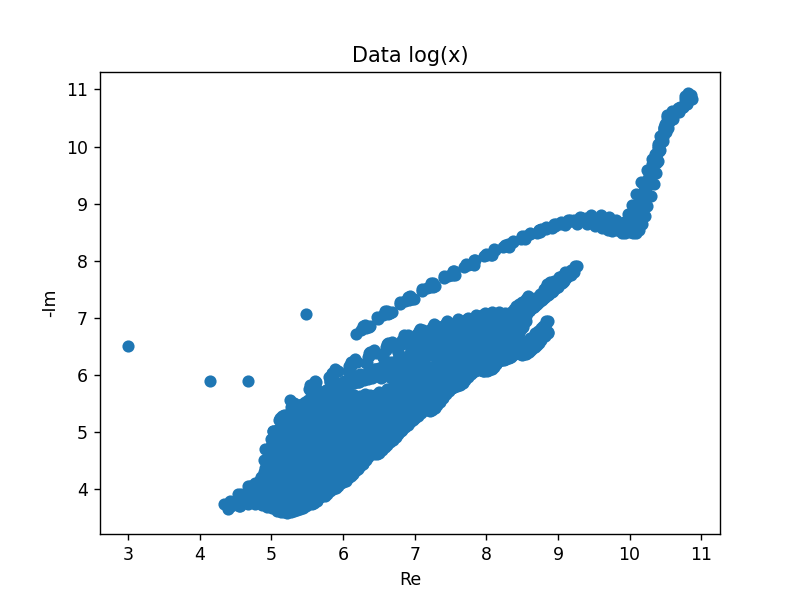

In [382]:
plt.scatter(df_re_unfilter_t, df_im_unfilter_t)
plt.title('Data log(x)')
plt.ylabel('-Im')
plt.xlabel('Re')
plt.show()

<IPython.core.display.Javascript object>


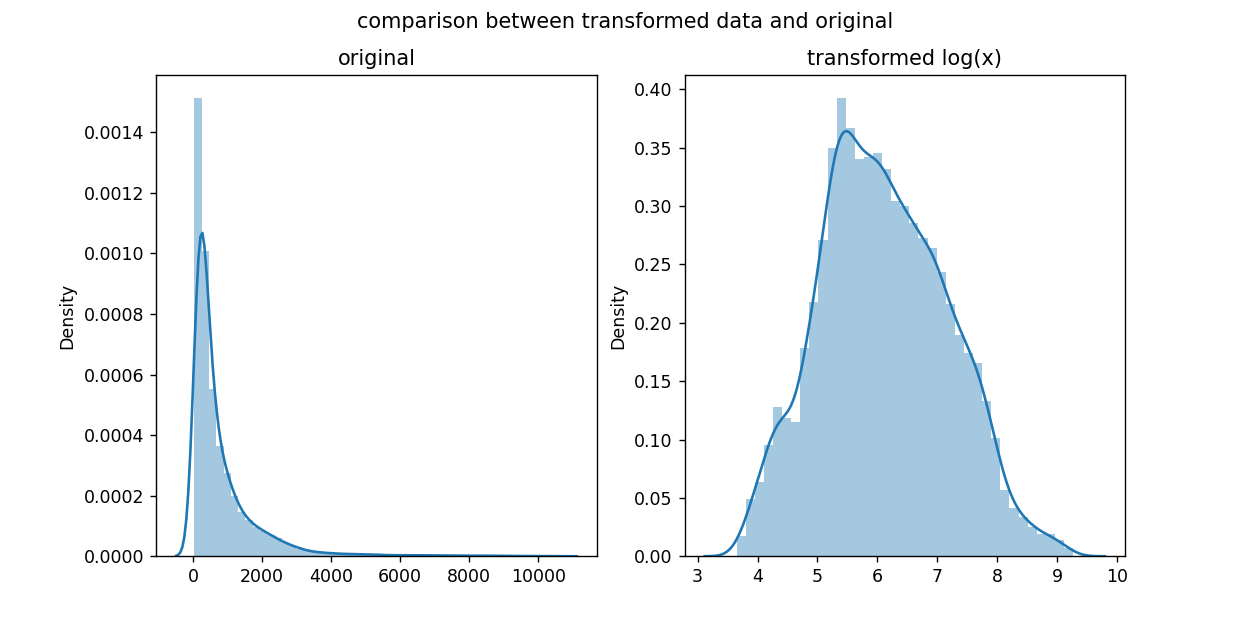

C:\Users\azhar\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\azhar\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:title={'center':'transformed log(x)'}, ylabel='Density'>

In [399]:
# more gaussian

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('comparison between transformed data and original')

axes[0].set_title('original')
sns.distplot(df_normal, ax=axes[0])

axes[1].set_title('transformed log(x)')
sns.distplot(df_normal_trans, ax=axes[1])


## training

probability distribution function

In [434]:
good_samples_train, good_samples_crv, good_samples_test = np.split(df_normal_trans.sample(frac=1, random_state=42), 
                                                            [int(.6*len(df_normal_trans)), int(.8*len(df_normal_trans))])

abnormal_samples_crv, abnormal_samples_test = train_test_split(df_abnormal_trans, test_size=0.5)


print('good samples: \n  train: {}\n  crv:    {}\n  test:  {}'.format(good_samples_train.shape, 
                                                                     good_samples_crv.shape, 
                                                                     good_samples_test.shape))
print('\nabnormal samples: \n crv: {} \n test: {}'.format(abnormal_samples_crv.shape, abnormal_samples_test.shape))

good samples: 
  train: (63, 72)
  crv:    (21, 72)
  test:  (22, 72)

abnormal samples: 
 crv: (20, 72) 
 test: (20, 72)


In [421]:
# probability using multivariate normal probability distribution function

def probability(df):
    # mean, covariance matrix
    mean = df.mean()
    cov_matrix = np.diag(np.std(df))
    
    from scipy.stats import multivariate_normal
    var = multivariate_normal.pdf(np.array(df), mean=mean, cov=cov_matrix)
    
    # return probability
    return pd.DataFrame(var, columns=['P(X)'])

In [435]:
good_p = probability(good_samples_train)

In [436]:
good_p

,P(X)
0,7.424201e-24
1,3.922085e-21
2,1.074815e-30
3,1.827582e-24
4,1.051340e-37
5,1.952692e-72
6,8.209485e-26
7,2.064045e-21
8,3.192701e-21
9,1.559556e-21


## cross validation

In [437]:
# label of normal/abnormal, normal = 0, abnormal = 1 based on abnormal cycle number above
label_good = pd.DataFrame(0, index=good_samples_crv.index, columns=['normal/abnormal'])
label_abnormal = pd.DataFrame(1, index=abnormal_samples_crv.index, columns=['normal/abnormal'])


print('abnormal samples shape: {}\nnormal samples shape: {}'.format(abnormal_samples_crv.shape, good_samples_crv.shape))

# combine the two
dfs = [abnormal_samples_crv, good_samples_crv]
labels = [label_abnormal, label_good]
crv = pd.concat(dfs)
crv_label = pd.concat(labels)

# random num to randomize the index (applies to both label and samples)
idx = np.random.permutation(crv.index)
crv = crv.loc[idx]
crv_label = crv_label.loc[idx]

# cross validation probability
crv_p = probability(crv)
crv_label = np.array(crv_label)
crv['normal/abnormal'] = crv_label
crv = crv[['normal/abnormal']+list(crv.columns.drop('normal/abnormal'))]


print('cross validation shape: {}'.format(crv_p.shape))

abnormal samples shape: (20, 72)
normal samples shape: (21, 72)
cross validation shape: (43, 1)


In [438]:
# 0 normal, 1 abnormal

crv

,normal/abnormal,-Im(Z)0.00931323,-Im(Z)0.0139698,-Im(Z)0.0209548,-Im(Z)0.0325963,-Im(Z)0.0488944,-Im(Z)0.0721775,-Im(Z)0.107102,-Im(Z)0.158325,-Im(Z)0.235159,-Im(Z)0.349246,-Im(Z)0.516884,-Im(Z)0.768341,-Im(Z)1.14087,-Im(Z)1.69268,-Im(Z)10001.0,-Im(Z)12.184,-Im(Z)130.089,-Im(Z)1390.0,-Im(Z)18.077,-Im(Z)193.035,-Im(Z)2.51224,-Im(Z)2063.0,-Im(Z)26.8198,-Im(Z)286.568,-Im(Z)3.72762,-Im(Z)3061.0,-Im(Z)39.8047,-Im(Z)425.149,-Im(Z)4542.0,-Im(Z)5.53438,-Im(Z)59.0552,-Im(Z)630.738,-Im(Z)6740.0,-Im(Z)8.21194,-Im(Z)87.684,-Im(Z)936.063,Re(Z)0.00931323,Re(Z)0.0139698,Re(Z)0.0209548,Re(Z)0.0325963,Re(Z)0.0488944,Re(Z)0.0721775,Re(Z)0.107102,Re(Z)0.158325,Re(Z)0.235159,Re(Z)0.349246,Re(Z)0.516884,Re(Z)0.768341,Re(Z)1.14087,Re(Z)1.69268,Re(Z)10001.0,Re(Z)12.184,Re(Z)130.089,Re(Z)1390.0,Re(Z)18.077,Re(Z)193.035,Re(Z)2.51224,Re(Z)2063.0,Re(Z)26.8198,Re(Z)286.568,Re(Z)3.72762,Re(Z)3061.0,Re(Z)39.8047,Re(Z)425.149,Re(Z)4542.0,Re(Z)5.53438,Re(Z)59.0552,Re(Z)630.738,Re(Z)6740.0,Re(Z)8.21194,Re(Z)87.684,Re(Z)936.063
7,1,5.622482,5.530036,5.359996,5.267688,5.172266,5.071699,4.975533,4.887488,4.806469,4.730401,4.644526,4.561424,4.478833,4.394237,3.655679,3.947278,3.609928,3.696704,3.875096,3.588515,4.305459,3.729654,3.795336,3.607075,4.221266,3.746013,3.728864,3.610718,3.747363,4.127633,3.679533,3.628676,3.717008,4.039556,3.631875,3.672171,6.668547,6.605171,6.524801,6.451239,6.379239,6.316070,6.246302,6.183014,6.118452,6.053953,5.993794,5.928506,5.867719,5.807070,4.397960,5.534713,5.268909,4.944965,5.486994,5.224838,5.746868,4.865016,5.442050,5.178356,5.690160,4.767400,5.395104,5.127962,4.667196,5.636021,5.356176,5.073172,4.549113,5.584762,5.309470,5.014362
101,0,6.833202,6.668406,6.615318,6.489478,6.411501,6.347456,6.290865,6.237592,6.175961,6.103095,6.046646,5.971731,5.911739,5.843286,4.911345,5.601340,5.571013,5.318987,5.586169,5.548185,5.778132,5.259473,5.582240,5.517497,5.719196,5.192145,5.586409,5.478662,5.118712,5.669526,5.587155,5.433656,5.035777,5.627564,5.583504,5.378006,8.104510,8.034595,7.981938,7.920345,7.864101,7.805026,7.749551,7.693782,7.636873,7.579398,7.520625,7.465340,7.409863,7.355424,5.401884,7.098028,6.695904,6.086304,7.044033,6.606364,7.302887,5.964748,6.985438,6.513918,7.251075,5.833257,6.922821,6.414917,5.696214,7.200044,6.853836,6.312230,5.542706,7.149187,6.777586,6.202809
38,1,6.425002,6.337374,6.163412,6.075328,5.995691,5.906100,5.830864,5.756036,5.689913,5.635379,5.563397,5.504770,5.440555,5.378680,4.756457,5.072614,4.934618,5.166105,5.019800,4.965798,5.312698,5.157802,4.977058,5.003886,5.249001,5.116226,4.944325,5.056067,5.037783,5.187559,4.925724,5.103178,4.923609,5.127926,4.926471,5.142307,7.672125,7.616564,7.543882,7.482023,7.427329,7.371502,7.319315,7.264457,7.208193,7.153412,7.101536,7.047622,6.995546,6.943248,4.996868,6.699083,6.417015,5.919270,6.652773,6.362357,6.892525,5.776429,6.607712,6.299785,6.842870,5.605361,6.562325,6.228120,5.416714,6.794040,6.515706,6.145132,5.223610,6.746065,6.467115,6.043893
33,1,6.298688,6.177151,6.016789,5.947102,5.855086,5.776184,5.698066,5.624259,5.559023,5.507025,5.449548,5.393991,5.339992,5.284041,4.716211,5.013804,4.813582,4.978284,4.962754,4.822634,5.228871,4.984750,4.917642,4.845430,5.174951,4.964298,4.872461,4.880132,4.907391,5.119729,4.843218,4.917086,4.820314,5.065275,4.824089,4.957347,7.529852,7.480490,7.422864,7.363083,7.305067,7.259102,7.204380,7.149571,7.095918,7.042522,6.992391,6.937916,6.887083,6.834462,4.916808,6.574848,6.264032,5.788513,6.523838,6.208280,6.782591,5.650789,6.472964,6.146670,6.730218,5.492180,6.421367,6.077498,5.316339,6.677950,6.370055,5.997802,5.118425,6.626425,6.318370,5.902089
32,1,6.527171,6.407940,6.269110,6.206148,6.123245,6.037269,5.961722,5.887853,5.820166,5.765724,5.706356,5.641105,5.583650,5.520516,4.886892,5.225655,5.126182,5.348069,5.180682,5.158164,5.459688,5.337903,5.144747,5.198862,5.399686,5.291912,5.115794,5.249778,5.203254,5.338682,5.102984,5.296060,5.085285,5.281370,5.108838,5.333071,7.790100,7.743777,7.693409,7.633263,7.578391,7.5

### select epsilon

In [439]:
# function to calculate true positives, false positives, and false negatives

def tpfpfn(ep, p):
    tp, fp, fn = 0, 0, 0
    for i in range(len(crv_label)):
        if p[i] <= ep and crv_label[i][0] == 1:
            tp += 1
        elif p[i] <= ep and crv_label[i][0] == 0:
            fp += 1
        elif p[i] > ep and crv_label[i][0] == 1:
            fn += 1
    return tp, fp, fn

# function calculate f1 score

def f1(ep, p):
    try:
        tp, fp, fn = tpfpfn(ep, p)
        prec = tp/(tp + fp)
        rec = tp/(tp + fn)
        f1 = 2*prec*rec/(prec + rec)
    except ZeroDivisionError:
        f1 = 0
    return f1

In [448]:
# epsilon

threshold = crv_p.mean()[0]

epsilon = []
for i in np.array(crv_p):
    ep = i[0]
    if ep <= threshold and ep != 0:
        epsilon.append(ep)

# find the f1 score for each epsilon and probability

f = []
for i in epsilon:
    f.append(f1(i, np.array(crv_p)))
    
# epsilon variable to use for all anomaly measurement
e = epsilon[np.array(f).argmax()]
print('epsilon: {}'.format(e))

epsilon: 1.2890878762800412e-31


## test

In [441]:
# returns a list of labels where anomaly = 1 and 0 otherwise
def detect_anomaly(df, ep):
    # test probability
    # label each with 1 if probability is smaller than epsilon
    df_t = df
    df_p = np.array(probability(df))
    label = []
    for i in range(len(df_t)):
        if np.array(df_p)[i] <= ep:
            label.append(1)
        else:
            label.append(0)
    return label

# plot
def graph_anom(df_anomaly):
    df_im_anomaly = df_anomaly[df_anomaly.columns.drop(list(df_anomaly.filter(regex='Re')))].loc[df_anomaly['label'] == 1]
    df_im_good = df_anomaly[df_anomaly.columns.drop(list(df_anomaly.filter(regex='Re')))].loc[df_anomaly['label'] == 0]

    df_re_anomaly = df_anomaly[df_anomaly.columns.drop(list(df_anomaly.filter(regex='Im')))].loc[df_anomaly['label'] == 1]
    df_re_good = df_anomaly[df_anomaly.columns.drop(list(df_anomaly.filter(regex='Im')))].loc[df_anomaly['label'] == 0]
    
    plt.title("Anomalies")
    
    plt.scatter(df_re_anomaly, df_im_anomaly, c='red', label='anomaly') # re and -im
    plt.scatter(df_re_good, df_im_good, label='good')
    plt.xlabel('Re')
    plt.ylabel('-Im')
    plt.legend()
    plt.show()

<IPython.core.display.Javascript object>


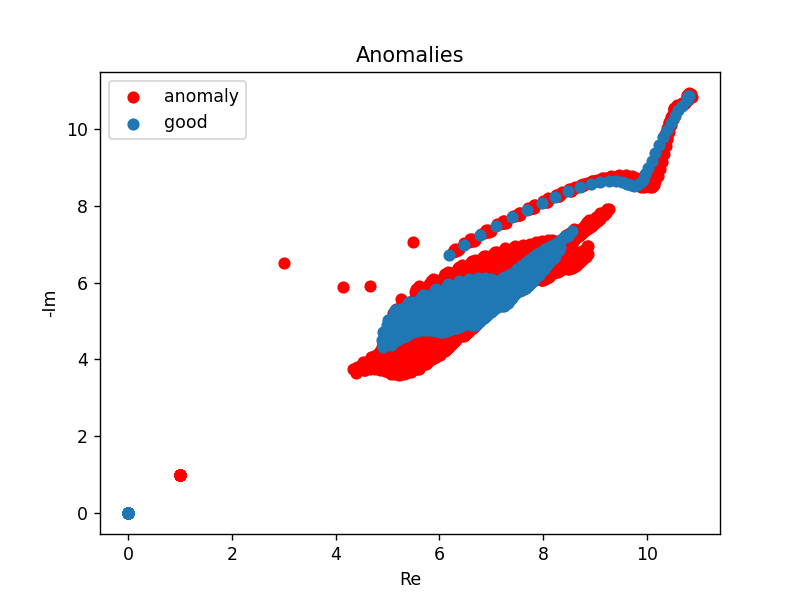

In [442]:
# anomaly detection with the whole dataset

df_unfilter_trans['label'] = detect_anomaly(df_unfilter_trans, e)
graph_anom(df_unfilter_trans)

<IPython.core.display.Javascript object>


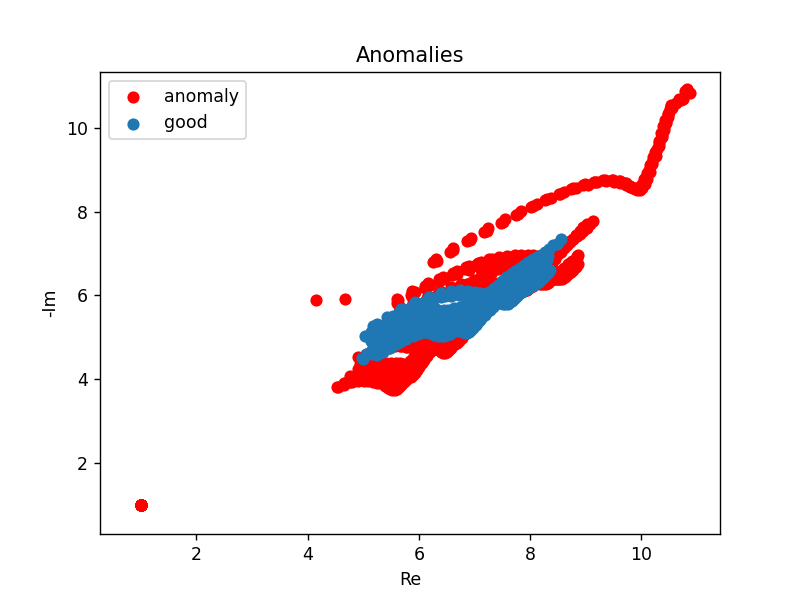

In [447]:
# anomaly detection with test data

dfs = [abnormal_samples_test, good_samples_test]
df_test = pd.concat(dfs)

df_test['label'] = detect_anomaly(df_test, e)
graph_anom(df_test)